# Extract Film Pigment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

In [57]:
image = ski.io.imread("Films/CINESTILL_800T.png")
image = ski.util.img_as_float64(image)

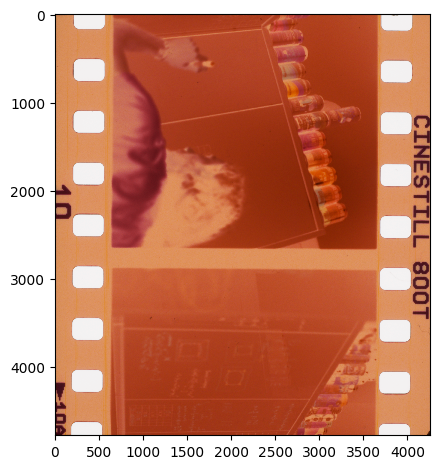

In [58]:
ski.io.imshow(image)

In [59]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)

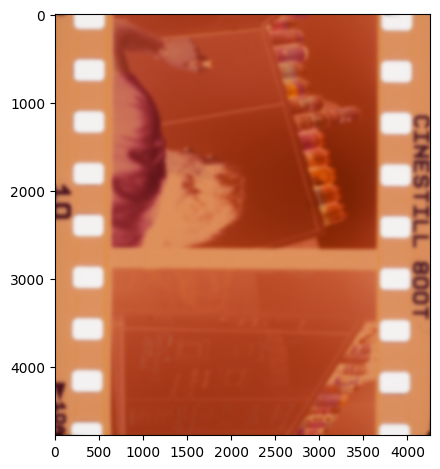

In [60]:
ski.io.imshow(blurred)

In [61]:
colours = blurred.reshape(-1, 3)

In [62]:
distribution, edges = np.histogramdd(colours, bins=256, range=[(0,1), (0,1), (0, 1)])

In [63]:
LIMIT_COLOURS = 50

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()
print(by_intensity)
sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

[11 23 31 13 22  4 30  8 21  0  5 24 18  6 12 16 15 28 10 20 37 42 36  9
 17 25 34 35 33 14 41  7  2 26 40 32 38 44  3 47 43 46 27 19 39 29  1 48
 45 49]


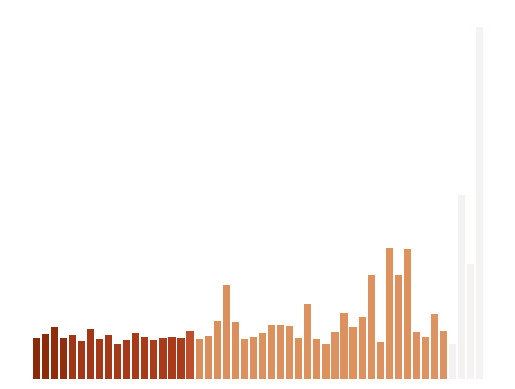

In [64]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [65]:
white = sorted_colours_by_intensity[-1]
pigment = sorted_colours_by_intensity[-18]

print(white, pigment)

[245 242 242] [221 145  93]


Adjusted Pigment: (230, 152, 97)


/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/.venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


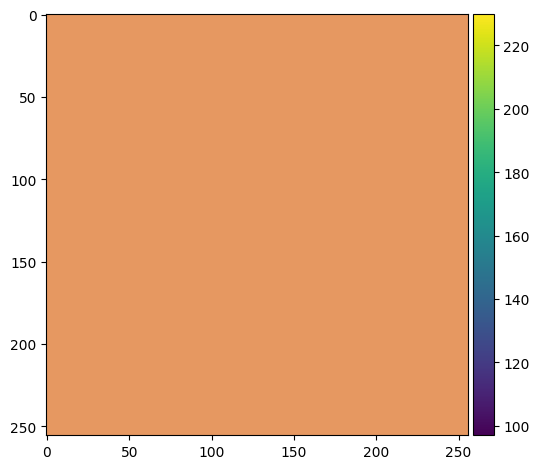

In [66]:
adjusted = (pigment * 255 / white).astype(np.uint8)
print(f"Adjusted Pigment: {tuple(adjusted.tolist())}")

colour_block = np.empty((256, 256, 3), dtype=np.uint8)
colour_block[:, :] = adjusted

ski.io.imshow(colour_block)

Setting to maximum lightness: (255, 168, 107)


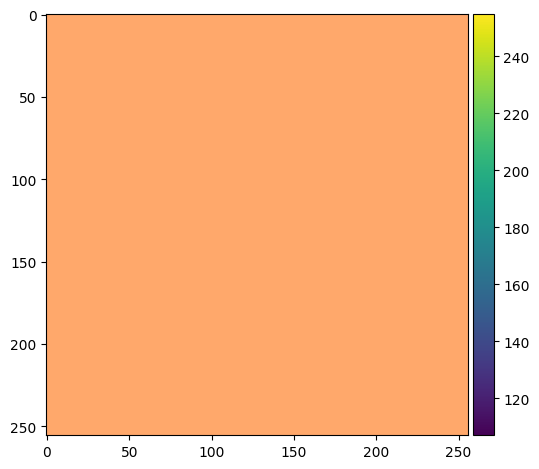

In [67]:
hsv = ski.color.rgb2hsv(np.array([[adjusted]]))
hsv[..., -1] = 1

adjusted = (ski.color.hsv2rgb(hsv).squeeze() * 255).astype(np.uint8)

print(f"Setting to maximum lightness: {tuple(adjusted.tolist())}")

colour_block = np.empty((256, 256, 3), dtype=np.uint8)
colour_block[:, :] = adjusted

ski.io.imshow(colour_block)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.271028..1.0].


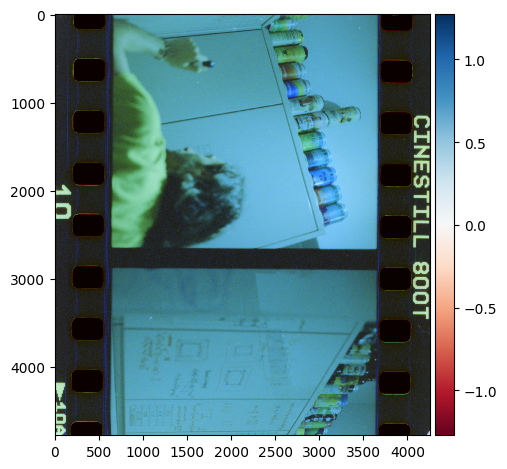

In [68]:
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.temperature import AdjustTemperature
import torch
# temperature_layer = AdjustTemperature(temperature=6000)
pigment_layer = RemoveEmulsionPigment(pigment=tuple(adjusted.tolist()), brightness_correction=False)

torch_image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
removed = pigment_layer((torch_image))
inverted = ski.util.invert(removed.permute(1, 2, 0).numpy())
ski.io.imshow(ski.util.invert(removed.permute(1, 2, 0).numpy()))


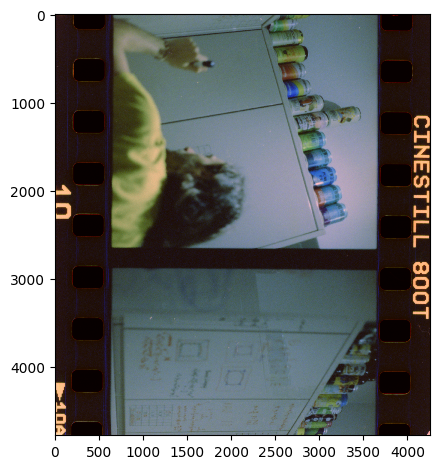

: 

In [ ]:
import torchvision.transforms.functional as F

torch_inverted = torch.tensor(inverted, dtype=torch.float32).permute(2, 0, 1)
torch_inverted[2] = F.adjust_brightness(torch_inverted[2], 0.55)
torch_inverted[1] = F.adjust_brightness(torch_inverted[1], 0.6)

torch_inverted = F.adjust_brightness(torch_inverted, 1.5)
torch_inverted = F.adjust_gamma(torch_inverted, 1.3)

ski.io.imshow(torch_inverted.permute(1, 2, 0).numpy())